In [1]:
from glob import glob
import os
from os import path as osp
import pandas as pd
import matplotlib.pyplot as plt

import sys
from os import pardir, getcwd
sys.path.append(osp.abspath(osp.join(getcwd(), pardir, pardir)))

from configuration import Config
config = Config()

In [2]:
def parse_filename(filename):
    filename = osp.split(filename)[-1]
    filename_root = osp.splitext(filename)[0]
    
    dataset, split, architecture, context_type, noise = filename_root.split('_', 4)
    noise = float(noise.replace('noise:', '').replace('-', '.'))
    
    return dataset, split, architecture, context_type, noise

def make_system_name(row) -> str:
    
    match row.architecture:
        case 'clpgpt':
            architecture = 'CC'
        case 'trf':
            architecture = 'TRF'
        case 'human':
            architecture = 'human'
    
    match row.context:
        case 'global':
            context = 'vis'
        case 'nocontext':
            context = 'tgt'
        case 'scene':
            context = 'sym'
            
    return f'{architecture}$_{{{context}}}$' if architecture != 'human' else '$human$'

In [4]:
ann_dir = osp.join(config.project_path, 'generated_inlg/compiled_annotations')
fig_location = osp.join(config.project_path, 'generated_inlg/figures')
if not osp.isdir(fig_location):
    os.mkdir(fig_location)

files = sorted(glob(f'{ann_dir}/**'))
# print(len(files))
# files

In [5]:
result_series = []
for path in files: 
    df = pd.read_csv(path, index_col=0)
    dataset, split, architecture, context_type, noise = parse_filename(path)
        
    name = osp.split(path)[-1].replace('.csv', '')
    
    out = pd.Series({
    'dataset': dataset, 
    'split': split,
    'architecture': architecture, 
    'context': context_type,
    'noise': noise,
    'A': 0,
    'F': 0,
    'O': 0,
    'M': 0,
    })
    out['system'] = make_system_name(out)

    category_scores = df.majority_annotation.value_counts() / len(df)
    for key, value in category_scores.to_dict().items():
        out[key] = value
    result_series.append(out)

In [6]:
results_df = pd.DataFrame(result_series)
results_df['architecture'] = pd.Categorical(results_df['architecture'], ["trf", "clpgpt", "human"])
results_df['context'] = pd.Categorical(results_df['context'], ["nocontext", "global", "scene"])
results_df = results_df.set_index('system').sort_values(
    by=['architecture', 'noise', 'context']
)
results_df = results_df[['noise', 'A', 'F', 'O', 'M']]
results_df[['A', 'F', 'O', 'M']] = results_df[['A', 'F', 'O', 'M']] * 100
results_df = results_df.rename(columns={
'A': '\% Adq.',
'F': '\% False',
'O': '\% Om.',
'M': '\% Misal.',
})

results_df

,noise,\% Adq.,\% False,\% Om.,\% Misal.
system,,,,,
TRF$_{tgt}$,0.0,84.0,10.5,5.0,0.5
TRF$_{vis}$,0.0,81.0,11.5,5.5,2.0
TRF$_{sym}$,0.0,89.0,7.0,3.5,0.5
TRF$_{tgt}$,0.5,66.5,28.0,4.0,1.5
TRF$_{vis}$,0.5,70.5,18.5,7.0,4.0
TRF$_{sym}$,0.5,81.5,14.5,2.5,1.5
TRF$_{tgt}$,1.0,1.5,75.5,19.5,3.5
TRF$_{vis}$,1.0,66.0,26.5,4.0,3.5
TRF$_{sym}$,1.0,68.0,22.0,1.5,8.5


In [7]:
print(results_df.to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} &  noise &  \% Adq. &  \% False &  \% Om. &  \% Misal. \\
system      &        &          &           &         &            \\
\midrule
TRF$_{tgt}$ &    0.0 &     84.0 &      10.5 &     5.0 &        0.5 \\
TRF$_{vis}$ &    0.0 &     81.0 &      11.5 &     5.5 &        2.0 \\
TRF$_{sym}$ &    0.0 &     89.0 &       7.0 &     3.5 &        0.5 \\
TRF$_{tgt}$ &    0.5 &     66.5 &      28.0 &     4.0 &        1.5 \\
TRF$_{vis}$ &    0.5 &     70.5 &      18.5 &     7.0 &        4.0 \\
TRF$_{sym}$ &    0.5 &     81.5 &      14.5 &     2.5 &        1.5 \\
TRF$_{tgt}$ &    1.0 &      1.5 &      75.5 &    19.5 &        3.5 \\
TRF$_{vis}$ &    1.0 &     66.0 &      26.5 &     4.0 &        3.5 \\
TRF$_{sym}$ &    1.0 &     68.0 &      22.0 &     1.5 &        8.5 \\
CC$_{tgt}$  &    0.0 &     46.0 &      46.5 &     7.0 &        0.5 \\
CC$_{vis}$  &    0.0 &     75.5 &      21.5 &     3.0 &        0.0 \\
CC$_{sym}$  &    0.0 &     70.5 &      17.5 &     5.5 &  

/tmp/ipykernel_9415/938731854.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.to_latex(escape=False))


In [8]:
results = []

for path in files: 
    df = pd.read_csv(path, index_col=0)
    dataset, split, architecture, context_type, noise = parse_filename(path)
        
    name = osp.split(path)[-1].replace('.csv', '')
    
    out = pd.Series({
    'A': 0,
    'F': 0,
    'O': 0,
    'M': 0,
    })

    category_scores = df.majority_annotation.value_counts() / len(df)
    for key, value in category_scores.to_dict().items():
        out[key] = value
        
    # out.sort_index().plot(kind='bar', title=f'{name} / #ann: {df.iloc[0].n_annotators}')
    # plt.show()
    
    results.append((dataset, split, architecture, context_type, noise, out.A, out.F, out.O, out.M))
    
# print(f'n = {len(df)}')

In [9]:
results

[('refcoco', 'testb', 'clpgpt', 'global', 0.0, 0.755, 0.215, 0.03, 0.0),
 ('refcoco', 'testb', 'clpgpt', 'global', 0.5, 0.555, 0.355, 0.065, 0.025),
 ('refcoco', 'testb', 'clpgpt', 'global', 1.0, 0.195, 0.685, 0.09, 0.03),
 ('refcoco', 'testb', 'clpgpt', 'nocontext', 0.0, 0.46, 0.465, 0.07, 0.005),
 ('refcoco', 'testb', 'clpgpt', 'nocontext', 0.5, 0.23, 0.61, 0.13, 0.03),
 ('refcoco', 'testb', 'clpgpt', 'nocontext', 1.0, 0.005, 0.845, 0.11, 0.04),
 ('refcoco', 'testb', 'clpgpt', 'scene', 0.0, 0.705, 0.175, 0.055, 0.065),
 ('refcoco', 'testb', 'clpgpt', 'scene', 0.5, 0.69, 0.195, 0.025, 0.09),
 ('refcoco', 'testb', 'clpgpt', 'scene', 1.0, 0.705, 0.16, 0.045, 0.09),
 ('refcoco', 'testb', 'human', 'global', 0.0, 0.905, 0.025, 0.06, 0.01),
 ('refcoco', 'testb', 'trf', 'global', 0.0, 0.81, 0.115, 0.055, 0.02),
 ('refcoco', 'testb', 'trf', 'global', 0.5, 0.705, 0.185, 0.07, 0.04),
 ('refcoco', 'testb', 'trf', 'global', 1.0, 0.66, 0.265, 0.04, 0.035),
 ('refcoco', 'testb', 'trf', 'nocontext',

In [10]:
all_df = pd.DataFrame(results, columns=['dataset', 'split', 'architecture', 'context_type', 'noise', 'A', 'F', 'O', 'M'])

clipgpt_df = all_df.loc[all_df.architecture == 'clpgpt']
clipgpt_context_df = clipgpt_df.loc[clipgpt_df.context_type == 'global'].set_index('noise')
clipgpt_nocontext_df = clipgpt_df.loc[clipgpt_df.context_type == 'nocontext'].set_index('noise')
clipgpt_scene_df = clipgpt_df.loc[clipgpt_df.context_type == 'scene'].set_index('noise')

transformer_df = all_df.loc[all_df.architecture == 'trf']
transformer_context_df = transformer_df.loc[transformer_df.context_type == 'global'].set_index('noise')
transformer_nocontext_df = transformer_df.loc[transformer_df.context_type == 'nocontext'].set_index('noise')
transformer_scene_df = transformer_df.loc[transformer_df.context_type == 'scene'].set_index('noise')

human_df = all_df.loc[all_df.architecture == 'human'].set_index('noise')

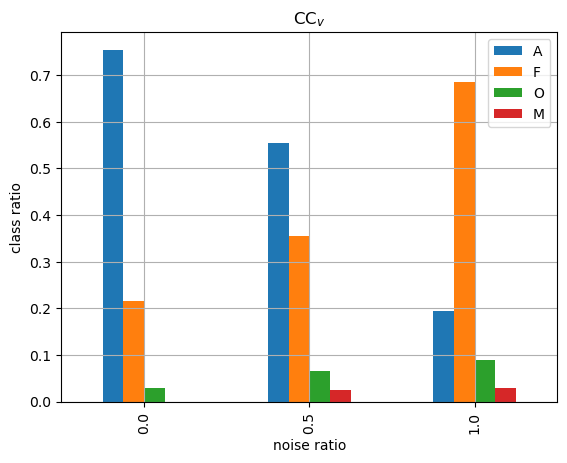

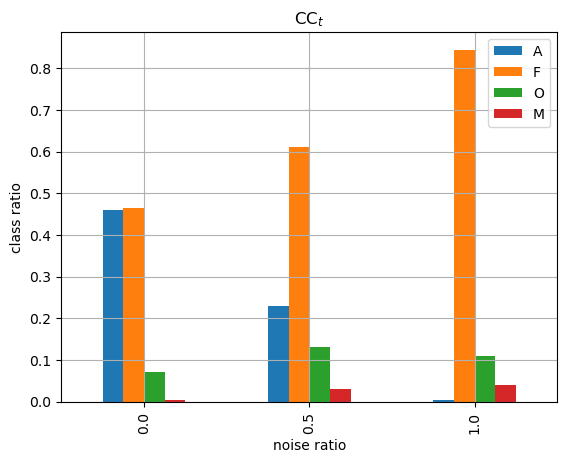

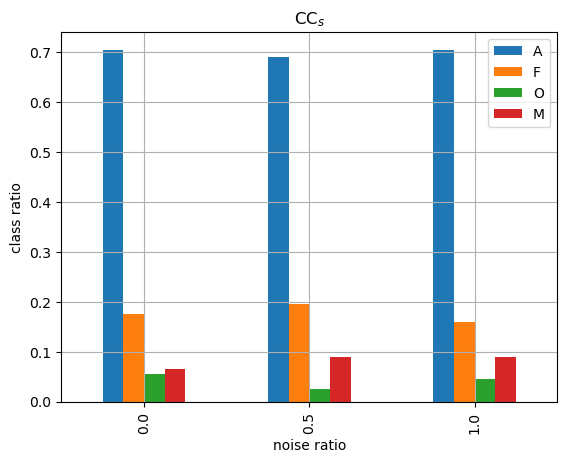

In [11]:
clipgpt_context_df.plot(kind='bar', title='CC$_{v}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'clip_context_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

clipgpt_nocontext_df.plot(kind='bar', title='CC$_{t}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'clip_nocontext_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

clipgpt_scene_df.plot(kind='bar', title='CC$_{s}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'clip_scene_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

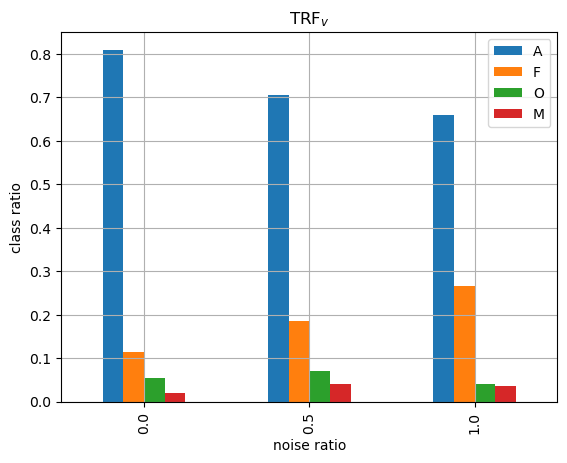

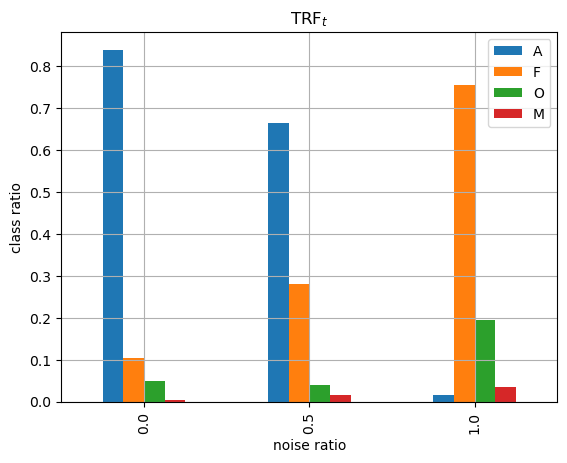

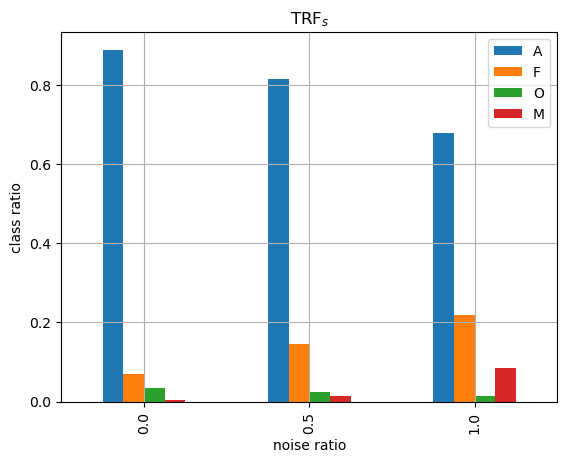

In [12]:
transformer_context_df.plot(kind='bar', title='TRF$_{v}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'retr_context_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

transformer_nocontext_df.plot(kind='bar', title='TRF$_{t}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'retr_nocontext_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

transformer_scene_df.plot(kind='bar', title='TRF$_{s}$')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'retr_scene_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()

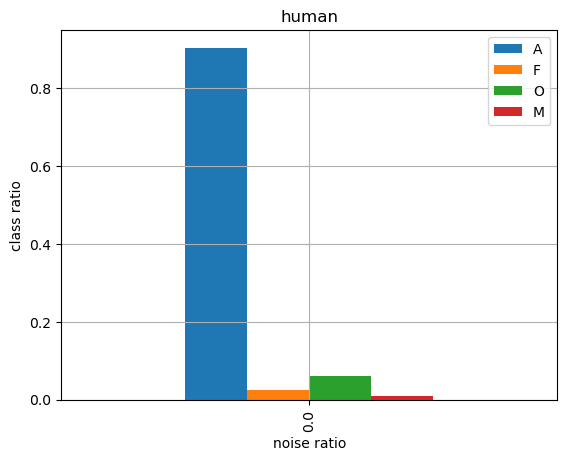

In [13]:
human_df.plot(kind='bar', title='human')
plt.ylabel('class ratio'); plt.xlabel('noise ratio')
plt.savefig(osp.join(fig_location, 'human_identification.png'), bbox_inches='tight')
plt.grid('dotted')
plt.show()